Создана новая папка: 'images_dataset/distorted'
Создана новая папка: 'images_dataset/ground_truth_filters'
Создана новая папка: 'images_dataset/kernel_data'
Найдено изображений для обработки: 17

--- Сохранение ядер ---
  -> Сохранено изображение ядра: images_dataset/ground_truth_filters\defocusgaussian.png
  -> Сохранены данные ядра: images_dataset/kernel_data\defocusgaussian.npy
  -> Сохранено изображение ядра: images_dataset/ground_truth_filters\defocusdisk.png
  -> Сохранены данные ядра: images_dataset/kernel_data\defocusdisk.npy
  -> Сохранено изображение ядра: images_dataset/ground_truth_filters\defocusring.png
  -> Сохранены данные ядра: images_dataset/kernel_data\defocusring.npy
  -> Сохранено изображение ядра: images_dataset/ground_truth_filters\motionlinearuniform.png
  -> Сохранены данные ядра: images_dataset/kernel_data\motionlinearuniform.npy
  -> Сохранено изображение ядра: images_dataset/ground_truth_filters\motionlinearexp.png
  -> Сохранены данные ядра: images_dataset/

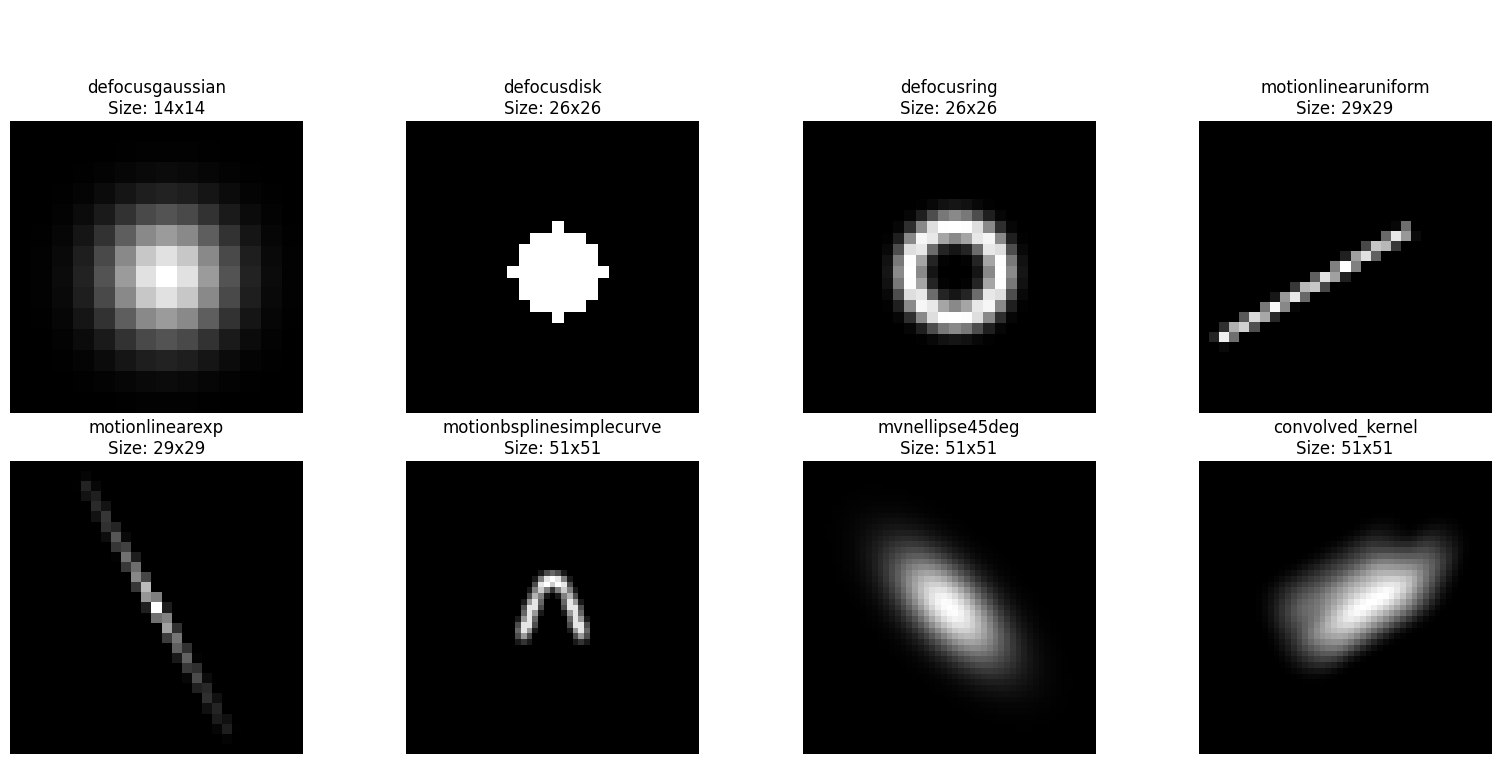


--- Обработка изображения: airplane.png ---
  -> Сохранено: images_dataset/distorted\airplane_defocusgaussian.png
  -> Сохранено: images_dataset/distorted\airplane_defocusgaussian_gaussian.png
  -> Сохранено: images_dataset/distorted\airplane_defocusgaussian_poisson.png
  -> Сохранено: images_dataset/distorted\airplane_defocusgaussian_saltpepper.png
  -> Сохранено: images_dataset/distorted\airplane_defocusdisk.png
  -> Сохранено: images_dataset/distorted\airplane_defocusdisk_gaussian.png
  -> Сохранено: images_dataset/distorted\airplane_defocusdisk_poisson.png
  -> Сохранено: images_dataset/distorted\airplane_defocusdisk_saltpepper.png
  -> Сохранено: images_dataset/distorted\airplane_defocusring.png
  -> Сохранено: images_dataset/distorted\airplane_defocusring_gaussian.png
  -> Сохранено: images_dataset/distorted\airplane_defocusring_poisson.png
  -> Сохранено: images_dataset/distorted\airplane_defocusring_saltpepper.png
  -> Сохранено: images_dataset/distorted\airplane_motionlinearu

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import shutil
import math
from typing import Tuple
from scipy.stats import multivariate_normal


from filters.blur import *
from filters.distributions import *
from filters.noise import *

class ImageFilterProcessor:
    def __init__(self, input_dir='images_dataset/original', output_dir='images_dataset/distorted', kernel_dir='images_dataset/ground_truth_filters', kernel_data_dir='images_dataset/kernel_data'): # Добавлена папка kernel_data_dir
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.kernel_dir = kernel_dir
        self.kernel_data_dir = kernel_data_dir # Инициализация новой папки
        self.kernel_ksize = 51 # Увеличен размер для сложных ядер

        # --- "Строительные блоки" для составного ядра ---
        _defocus_disk_config = {'name': 'defocusdisk', 'class': DefocusBlur, 'params': {'psf': uniform_distribution, 'param': 4.0}}
        _motion_linear_config = {'name': 'motionlinearuniform', 'class': MotionBlur, 'params': {'psf': uniform_distribution, 'param': 7.0, 'angle': 30}}
        _bspline_config = {
            'name': 'motionbsplinesimplecurve', 
            'generator_func': generate_bspline_motion_kernel, 
            'params': {
                'ksize': self.kernel_ksize, 
                'thickness': 3,
                'points': [(-5, 5), (0, -5), (5, 5)]
            }
        }

        self.blur_configs = [
            {'name': 'defocusgaussian', 'class': DefocusBlur, 'params': {'psf': gaussian_distribution, 'param': 2.0}},
            {'name': 'defocusdisk', 'class': DefocusBlur, 'params': {'psf': uniform_distribution, 'param': 4.0}},
            #{'name': 'defocuscone', 'class': DefocusBlur, 'params': {'psf': linear_decay_distribution, 'param': 4.0}},
            {'name': 'defocusring', 'class': DefocusBlur, 'params': {'psf': ring_distribution, 'param': 4.0}},
            {'name': 'motionlinearuniform', 'class': MotionBlur, 'params': {'psf': uniform_distribution, 'param': 7.0, 'angle': 30}},
            {'name': 'motionlinearexp', 'class': MotionBlur, 'params': {'psf': exponential_decay_distribution, 'param': 7.0, 'angle': 120}},
            {
                'name': 'motionbsplinesimplecurve', 
                'generator_func': generate_bspline_motion_kernel, 
                'params': {
                    'ksize': self.kernel_ksize, 
                    'thickness': 3,
                    'points': [(-5, 5), (0, -5), (5, 5)]
                }
            },
            # {
            #     'name': 'motionbsplinecurlcurve', 
            #     'generator_func': generate_bspline_motion_kernel, 
            #     'params': {
            #         'ksize': self.kernel_ksize, 
            #         'thickness': 5,
            #         'points': [(-10, 10), (0, -10), (2, 2)]
            #     }
            # },
            # {
            #     'name': 'mvnsymmetric', 
            #     'generator_func': generate_multivariate_normal_kernel, 
            #     'params': {'ksize': self.kernel_ksize, 'cov': [[20.0, 0.0], [0.0, 20.0]]}
            # },
            # {
            #     'name': 'mvnstretchedx', 
            #     'generator_func': generate_multivariate_normal_kernel, 
            #     'params': {'ksize': self.kernel_ksize, 'cov': [[40.0, 0.0], [0.0, 10.0]]}
            # },
            {
                'name': 'mvnellipse45deg', 
                'generator_func': generate_multivariate_normal_kernel, 
                'params': {'ksize': self.kernel_ksize, 'cov': [[40.0, 25.0], [25.0, 40.0]]}
            },
            # --- НОВОЕ СОСТАВНОЕ ЯДРО ---
            {
                'name': 'convolved_kernel',
                'generator_func': self._generate_convolved_kernel,
                'params': {
                    'ksize': self.kernel_ksize,
                    'configs': [
                        _defocus_disk_config,
                        _motion_linear_config,
                        _bspline_config
                    ]
                }
            },
            # {
            #     'name': 'surface_bspline_cross', 
            #     'generator_func': generate_2d_bspline_surface_kernel, 
            #     'params': {
            #         'ksize': self.kernel_ksize,
            #         # Задаем сетку 5x5 контрольных "высот".
            #         # Это создаст ядро в форме гладкого креста.
            #         'control_points': np.array([
            #             [0, 0, 1, 0, 0],
            #             [0, 0, 1, 0, 0],
            #             [1, 1, 1, 1, 1],
            #             [0, 0, 1, 0, 0],
            #             [0, 0, 1, 0, 0]
            #         ])
            #     }
            # },
            # {
            #     'name': 'surface_bspline_hills', 
            #     'generator_func': generate_2d_bspline_surface_kernel, 
            #     'params': {
            #         'ksize': self.kernel_ksize,
            #         # Создаст ядро с четырьмя гладкими "холмами" по углам.
            #         'control_points': np.array([
            #             [1, 0, 0, 0, 1],
            #             [0, 0, 0, 0, 0],
            #             [0, 0, 0.5, 0, 0],
            #             [0, 0, 0, 0, 0],
            #             [1, 0, 0, 0, 1]
            #         ])
            #     }
            # }
        ]

        self.noise_configs = [
            {'name': 'gaussian', 'class': GaussianNoise, 'params': {'param': 3.0}},
            {'name': 'poisson', 'class': PoissonNoise, 'params': {'param': 0.03}},
            {'name': 'saltpepper', 'class': SaltAndPepperNoise, 'params': {'param': (1, 1, 1000)}}
        ]


    def _generate_convolved_kernel(self, ksize: int, configs: list, **kwargs) -> np.ndarray:
        base_kernels = []
        total_size = 0
        for config in configs:
            if 'generator_func' in config:
                config['params']['ksize'] = max(config['params'].get('ksize', 0), ksize)
                # Если генератор - это метод этого же класса, вызываем через self
                if hasattr(self, config['generator_func'].__name__):
                     k = getattr(self, config['generator_func'].__name__)(**config['params'])
                else: # Если это внешняя функция
                     k = config['generator_func'](**config['params'])
            elif 'class' in config:
                blur_filter = config['class'](**config['params'])
                k = blur_filter.generate_kernel()
            else:
                continue
            base_kernels.append(k)
            total_size += k.shape[0]

        if not base_kernels:
            return np.zeros((ksize, ksize))

        convolved_kernel = np.zeros((total_size, total_size))
        center = total_size // 2
        convolved_kernel[center, center] = 1.0

        for k in base_kernels:
            convolved_kernel = cv2.filter2D(convolved_kernel, -1, k)
        
        start = center - (ksize // 2)
        end = start + ksize
        final_kernel = convolved_kernel[start:end, start:end]

        if final_kernel.sum() > 0:
            return final_kernel / final_kernel.sum()
        return final_kernel

    def _apply_all_filters(self, image: np.ndarray) -> Tuple[dict, dict]:
        results, kernels = {}, {}

        for blur_config in self.blur_configs:
            blur_name = blur_config['name']
            
            if 'generator_func' in blur_config:
                # Специальная обработка для нашего мета-генератора
                if blur_config['generator_func'] == self._generate_convolved_kernel:
                    kernel = self._generate_convolved_kernel(**blur_config['params'])
                else:
                    kernel = blur_config['generator_func'](**blur_config['params'])
                
                class GenericFilter(FilterBase):
                    def __init__(self, k):
                        super().__init__({}, 'blur') 
                        self.k = k
                    def generate_kernel(self): return self.k
                    def filter(self, img): return cv2.filter2D(img, -1, self.k)
                    def discription(self) -> str: return "Generic Filter"
                blur_filter = GenericFilter(kernel)

            elif 'class' in blur_config:
                blur_filter = blur_config['class'](**blur_config['params'])
                kernel = blur_filter.generate_kernel()
            else:
                continue

            kernels[blur_name] = (kernel, f"{blur_name}\nSize: {kernel.shape[0]}x{kernel.shape[1]}")
            blurred_image = blur_filter.filter(image)
            results[blur_name] = blurred_image

            for noise_config in self.noise_configs:
                noise_name = noise_config['name']
                noise_filter = noise_config['class'](**noise_config['params'])
                noisy_image = noise_filter.filter(blurred_image)
                final_name = f"{blur_name}_{noise_name}"
                results[final_name] = noisy_image
            
        return results, kernels

    def _show_plot(self, kernels: dict):
        kernel_items = list(kernels.items())
        num_kernels = len(kernel_items)
        cols = 4
        rows = math.ceil(num_kernels / cols)
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        plt.style.use('dark_background')
        fig.suptitle('Сгенерированные ядра размытия', fontsize=16)
        axes = axes.flatten()

        for i, (name, (kernel, description)) in enumerate(kernel_items):
            axes[i].imshow(kernel, cmap='gray')
            axes[i].set_title(description)
            axes[i].axis('off')

        for i in range(num_kernels, len(axes)):
            axes[i].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def _save_kernels(self, kernels: dict):
        print("\n--- Сохранение ядер ---")
        for name, (kernel, _) in kernels.items():
            if np.max(kernel) > 0:
                kernel_img = (kernel / np.max(kernel)) * 255
            else:
                kernel_img = kernel
            kernel_img = kernel_img.astype(np.uint8)
            output_path_img = os.path.join(self.kernel_dir, f"{name}.png")
            cv2.imwrite(output_path_img, kernel_img)
            print(f"  -> Сохранено изображение ядра: {output_path_img}")
            
            output_path_data = os.path.join(self.kernel_data_dir, f"{name}.npy")
            np.save(output_path_data, kernel)
            print(f"  -> Сохранены данные ядра: {output_path_data}")

    def process_images(self):
        # Обновляем список папок для создания/очистки
        for directory in [self.output_dir, self.kernel_dir, self.kernel_data_dir]:
            if os.path.exists(directory):
                print(f"Удаление существующей папки: '{directory}'...")
                shutil.rmtree(directory)
            os.makedirs(directory)
            print(f"Создана новая папка: '{directory}'")

        image_paths = glob.glob(os.path.join(self.input_dir, '*.[pP][nN][gG]')) + \
                      glob.glob(os.path.join(self.input_dir, '*.[jJ][pP][gG]')) + \
                      glob.glob(os.path.join(self.input_dir, '*.[jJ][pP][eE][gG]'))
        if not image_paths:
            print(f"Ошибка: Не найдено изображений в папке '{self.input_dir}'.")
            return
        print(f"Найдено изображений для обработки: {len(image_paths)}")

        dummy_image = np.zeros((100, 100, 3), dtype=np.uint8)
        _, kernels_for_plot = self._apply_all_filters(dummy_image)
        self._save_kernels(kernels_for_plot)
        print("\nОтображение всех сгенерированных ядер...")
        self._show_plot(kernels_for_plot)
        
        for image_path in image_paths:
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            print(f"\n--- Обработка изображения: {os.path.basename(image_path)} ---")
            
            image = cv2.imread(image_path)
            if image is None:
                print(f"Не удалось прочитать изображение: {image_path}. Пропускаю.")
                continue
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            filtered_results, _ = self._apply_all_filters(image_rgb)
            
            for filter_name, result_image in filtered_results.items():
                output_filename = f"{base_name}_{filter_name}.png"
                output_path = os.path.join(self.output_dir, output_filename)
                result_image_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(output_path, result_image_bgr)
                print(f"  -> Сохранено: {output_path}")

        print("\nОбработка всех изображений завершена.")

if __name__ == "__main__":
    processor = ImageFilterProcessor()
    processor.process_images()